In [8]:
import sys
import os
directory = os.path.abspath(os.path.join('..'))
sys.path.append(directory)
import numpy as np
from matplotlib import pyplot as plt
from scripts.model_params import *
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scripts.cell_model_general import *
import sksundae as sun
import pandas as pd
from scripts.batch_culture_simulation import *
import joblib
from pathlib import Path
import os
import time
from scripts.surrogate_calculation import *
from scripts.generate_training_data_functions import *

ModuleNotFoundError: No module named 'scripts.cell_model_jacobian'

Defining and importing base parameters

In [2]:
# defining parameters
sS0 = 0.5; cultvol = 1.25 #quality of the nutrients and volume of the culture
vX = 726; kX = 1e3 # X export parameters
tmax = 2000; runintmax = 1e6 #simulation time parameters

N0  = 1e6
xS0 = ((10*cultvol)/180)*6.02e23; # amount of glucose in media = 10g/L in 1.25L working vol in 3L vessel
M0 = 1e8 

Defining the system topology parameters

In [3]:
#topology
ctT         = 0; # TF_P control on TX of T
ctE         = 1; # TF_P control on TX of E
ctEprod     = 0; # TF_P control on TX of Ep
ctTF        = 0; # TF_P control on TF
ctEprotease = -1; # TF_P control on Eprotease
ctTprod     = 0; # TF_P control on TX of the engineered P transporter Tp

#functions within topology (0 = Mannan 2025 TX regulation model)
T_TXmodel         = 0
E_TXmodel         = 0
Eprod_TXmodel     = 0
TF_TXmodel        = 0
Eprotease_TXmodel = 0
Tprod_TXmodel     = 0

topology = [ctT, ctE, ctEprod, ctTF, ctEprotease, ctTprod, T_TXmodel, E_TXmodel, 
            Eprod_TXmodel, TF_TXmodel, Eprotease_TXmodel, Tprod_TXmodel]

creating the host and engineered parameter arrays

In [4]:
base_params = [xS0, runintmax, tmax, N0, topology]

hPR0, xPR0 = model_params(sS0, vX, kX, cultvol)
hPR = np.array(hPR0)
xPR = np.array(xPR0)
    #    0   1     2      3       4         5        6        7           8
#xpPR = [w0, wE, wEprod, wTF, wEprotease, wTprod, k_Eprod, Km_Eprod, k_Eprotease, 
#            9            10       11     12    13    14         15         16
#        Km_Eprotease, k_Tprod, Km_Tprod, K_T, K_E, K_Eprod, K_Eprotease, K_Tprod, 
#        17      18      19       20     21   22
#        K_TF, kdiffP, VolCell, VolCult, ksf, ksr

Setting specific circuit parameters

In [6]:
wE = 20; wEprod = 20; wTF = 20; wEprotease = 2;
K_E = 0.3; K_Eprotease = 1.0

xPR[[1, 2, 3, 4, 13, 15]] = [wE, wEprod, wTF, wEprotease, K_E, K_Eprotease]

Setting the range of wEp and xS0 and creating a meshgrid

In [7]:
no_xS0 = 20; no_W = 20; no_K = 10
W_mult = 2; K_mult = 2

#setting the range for xS0
xS0_split_point = 1E5
xS0_split_prop = 0.5

xS0_range = np.concatenate([np.logspace(np.log10(1E2), np.log10(xS0_split_point), num=int(no_xS0*xS0_split_prop)), np.logspace(np.log10(xS0_split_point), np.log10(xS0), num=int(no_xS0*(1-xS0_split_prop)))])
wE_range = np.linspace(0, 20, no_W)
wEp_range = np.linspace(0, 20, no_W)
wTF_range = np.linspace(0, 20, no_W)
KE_range = np.linspace(0, 3, no_K)
KEp_range = np.linspace(0, 3, no_K)

Creating parameter arrays to loop over

In [8]:
parameter_sampler = latin_hypercube_sampling; sampler_function_params = [400, 42]; 

array_index_range_triples = [
    [1, 1, wEp_range],
    [0, 0, np.log10(xS0_range)], 
    [1, -1, wE_range],
    [1, 3, wTF_range],
    [1, 14, KE_range],
    [1, 15, KEp_range],
    ]
cartesian_product_array, cartesian_parameter_values = parameter_sampler(array_index_range_triples, *sampler_function_params)
cartesian_parameter_values[:, 1] = 10**cartesian_parameter_values[:, 1]
cartesian_product_array[:, 1, 2] = 10**cartesian_product_array[:, 1, 2]


[[ 0.         79.1136137 ]
 [ 2.         22.621234  ]
 [ 0.         12.74305092]
 [ 0.          5.87460199]
 [ 0.          1.04898322]
 [ 0.          1.81019948]]


Looping over parameter arrays and simulating

In [9]:
cell_params = [hPR, xPR]
tmax_values = [1E6]
base_params = [tmax, N0, topology]

data_points = []
successful_params = []

timeout_seconds = 60  # max runtime per simulation
progress_int = max(1, int(len(cartesian_product_array) / 100))

class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException()

# Set the signal handler
signal.signal(signal.SIGALRM, timeout_handler)

for i, array in enumerate(cartesian_product_array, start=1):
    # Set cell parameters for this case
    for parameter_case in array:
        cell_params[parameter_case[0]][parameter_case[1]] = parameter_case[2]

    output = None
    start_time = time.time()

    # Try each tmax value
    for tmax_try in tmax_values:
        base_params[0] = tmax_try
        try:
            signal.alarm(10)  # seconds
            output = surrogate_calculation(base_params, cell_params[0], cell_params[1])
            signal.alarm(0)  # seconds
            break  # success, exit tmax loop

        except Exception as e:
            print(e)
            # If other error occurs, try next tmax or skip
            continue

    if output is not None:
        data_points.append(output)
        successful_params.append(cartesian_parameter_values[i-1])
    else:
        print(f"Skipped pair {i} after all tmax attempts failed or timed out.")

    # Progress display
    if i % progress_int == 0 or i == len(cartesian_product_array):
        #clear_output(wait=True)
        print(f"Progress: {i}/{len(cartesian_product_array)} ({i/len(cartesian_product_array)*100:.1f}%)")

print(f"\nFinished sweep. {len(successful_params)} / {len(cartesian_product_array)} successful runs.")

AttributeError: module 'signal' has no attribute 'SIGALRM'

Plotting

Text(0.5, 0, 'log(xS0)')

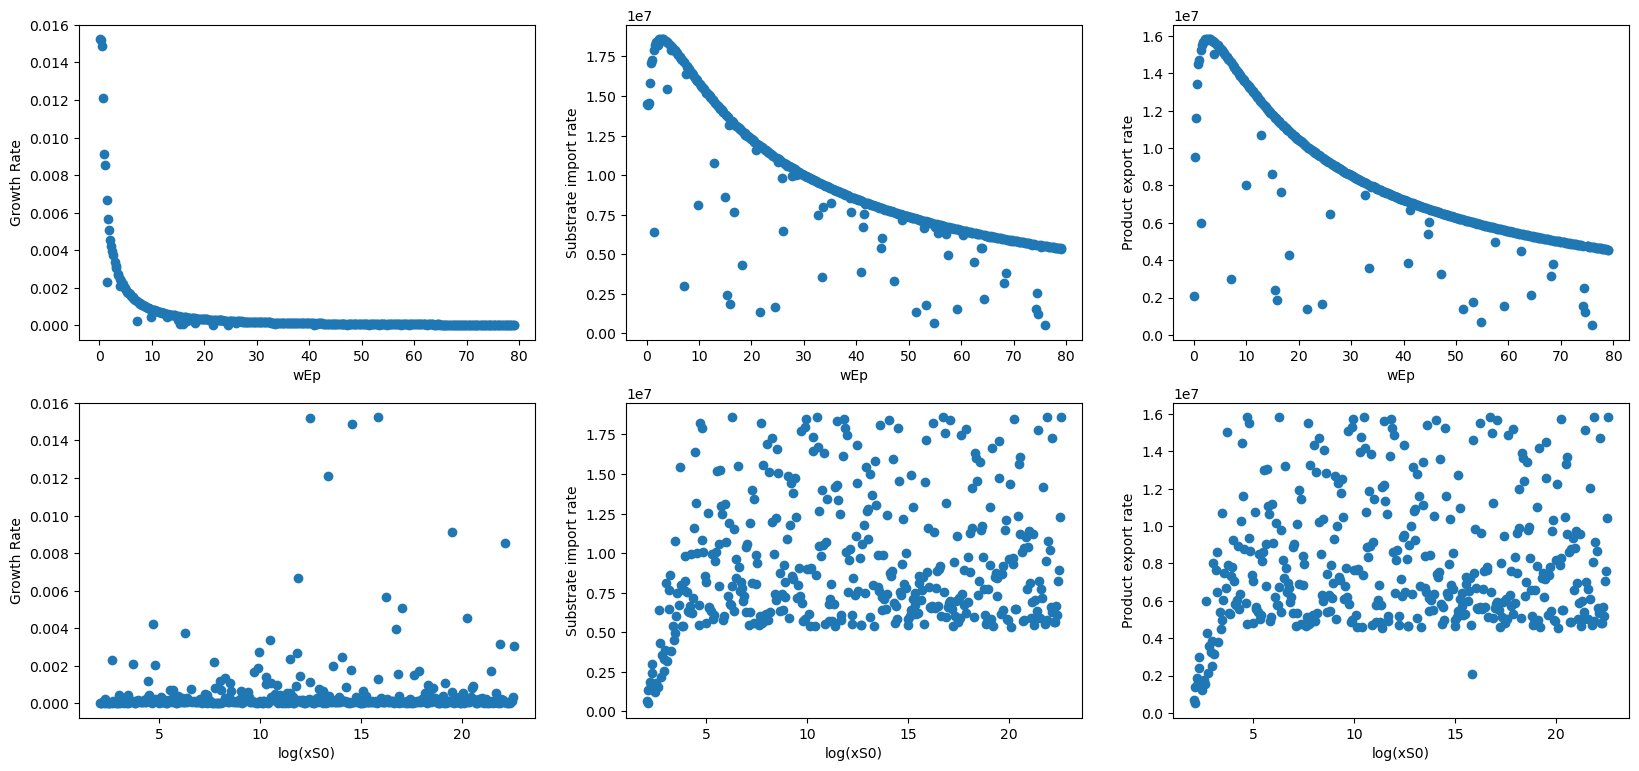

In [ ]:
successful_params = np.array(successful_params); data_points = np.array(data_points)

fig, axs = plt.subplots(2, 3, figsize=(20, 9))
axs[0][0].scatter(successful_params[:, 0], data_points[:, 0])
axs[0][0].set_xlabel("wEp")
axs[0][0].set_ylabel("Growth Rate")
axs[0][1].scatter(successful_params[:, 0], data_points[:, 1])
axs[0][1].set_xlabel("wEp")
axs[0][1].set_ylabel("Substrate import rate")
axs[0][2].scatter(successful_params[:, 0], data_points[:, 2])
axs[0][2].set_xlabel("wEp")
axs[0][2].set_ylabel("Product export rate")

axs[1][0].scatter(np.log10(successful_params[:, 1]), data_points[:, 0])
axs[1][0].set_ylabel("Growth Rate")
axs[1][0].set_xlabel("log(xS0)")
axs[1][1].scatter(np.log10(successful_params[:, 1]), data_points[:, 1])
axs[1][1].set_ylabel("Substrate import rate")
axs[1][1].set_xlabel("log(xS0)")
axs[1][2].scatter(np.log10(successful_params[:, 1]), data_points[:, 2])
axs[1][2].set_ylabel("Product export rate")
axs[1][2].set_xlabel("log(xS0)")

Now saving

In [ ]:
if INDUCED:
    np.savez_compressed(directory+"/data/surrogate_training_data_"+name+"_INDUCED.npz", inputs=successful_params, targets=data_points)
else:
    np.savez_compressed(directory+"/data/surrogate_training_data_"+name+"_NOT_INDUCED.npz", inputs=successful_params, targets=data_points)

In [ ]:
if INDUCED:
    data = np.load(directory+"/data/surrogate_training_data_"+name+"_INDUCED.npz")
else:
    data = np.load(directory+"/data/surrogate_training_data_"+name+"_NOT_INDUCED.npz")